# Heat Conduction Data Set

**Intputs**

- `qprime`: Linear heat generation rate ($\frac{W}{m}$)
- `mdot`: Mass flow rate ($\frac{g}{s}$)
- `Tin`: Temperature of the fuel boundary ($K$)
- `R`: Fuel radius ($m$)
- `L`: Fuel length ($m$)
- `Cp`: Heat capacity ($\frac{J}{g \cdot K}$)
- `k`: Thermal conductivity ($\frac{W}{m \cdot K}$)

**Output**

- `T`: Fuel centerline temperature ($K$)

This data set consists of 1000 data points with 7 inputs and 1 output. The data set was constructed through Latin hypercube sampling of the 7 input parameters for heat conduction through a fuel rod. These samples were then used to solve for the fuel centerline temperature analysically. The geometry of the problem is illustrated below and it is assumed volumetric heat generation is uniform radially. The problem is defined by

\begin{equation}
    \frac{1}{r}\frac{d}{dr}(kr\frac{dT}{dr}) + q''' = 0,
\end{equation}
with two boundary conditions: $\frac{dT}{dr}|_{r = 0} = 0$ and $T(R) = T_{in}$. Therefore, the temperature profile in the fuel is

\begin{equation}
    T(r) = \frac{q'}{4\pi k}(1 - (r/R)^2) + T_{in}.
\end{equation}

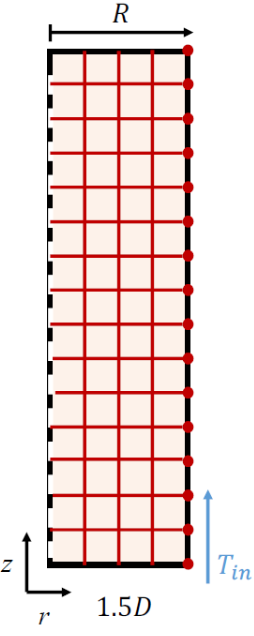

In [8]:
import pyMAISE as mai
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import uniform, randint
from sklearn.model_selection import ShuffleSplit

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

Starting any pyMAISE job requires initialization, this includes the definition of global settings used throughout pyMAISE. For this problem the pyMAISE defaults are used:

- `verbosity`: 0 $\rightarrow$ pyMAISE prints no outputs,
- `random_state`: None $\rightarrow$ No random seed is set,
- `test_size`: 0.3 $\rightarrow$ 30% of the data is used for testing,
- `num_configs_saved`: 5 $\rightarrow$ The top 5 hyper-parameter configurations are saved for each model.

The settings are initialized and the heat conduction preprocessor specific to this data set is retrieved.

In [9]:
global_settings = mai.settings.init()
preprocessor = mai.load_heat()

The heat conduction data set has 7 inputs

In [10]:
preprocessor.inputs.head()

,qprime,mdot,Tin,R,L,Cp,k
0,35987.992759,206.185816,573.151869,0.004901,3.448155,4.096140,0.960945
1,38481.055798,192.378974,573.150960,0.004966,3.436833,4.249182,1.011272
2,39143.292108,205.076928,573.153975,0.005210,3.681457,4.237540,0.994646
3,38687.579644,199.594924,573.150777,0.004864,3.624594,4.158921,1.028158
4,40469.561181,194.142084,573.150977,0.004914,3.731222,4.244278,1.018738


and 1 output with 1000 data points.

In [11]:
preprocessor.outputs.head()

,T
0,1034.133784
1,1170.316042
2,1164.893565
3,1205.250040
4,1444.718666


To better understand the data here is a correlation matrix of the data.

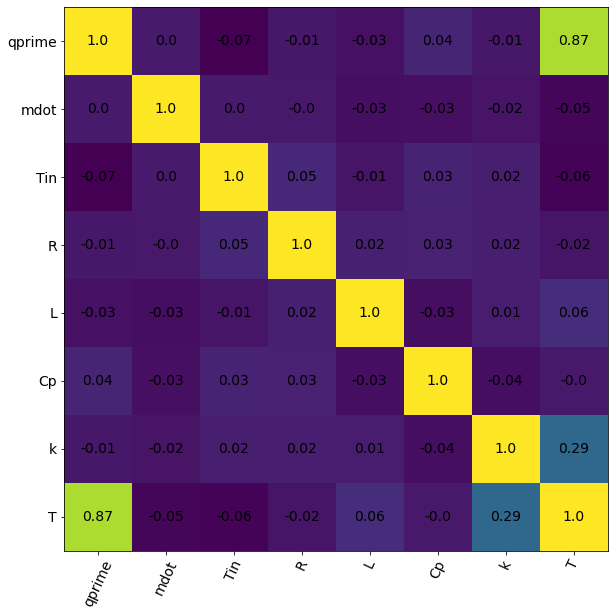

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax, colorbar=False, annotations=True)

As expected there is a strong correlation between linear heat generation rate, `qprime`, and the centerline fuel temperature, `T`.

Prior to model training the data is min-max scaled to make each feature's effect size comperable. Additionaly, this can improve the performance of some models.

In [13]:
data = preprocessor.min_max_scale()

## Model Initialization

Given this data set has a 1-dimensional output we will compare the performance of 7 machine learning (ML) models:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Support vector regression: `svr`,
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Sequential dense neural networks: `nn`.

For hyper-parameter tuning each model must be initialized. We will use the Scikit-learn defaults for the classical ML models (`linear`, `lasso`, `svr`, `dtree`, `rforest`, and `knn`); therefore, they are only specified in the `models` parameter of the `model_settings` dictionary. However, we must specify many parameters for the `nn` model that define the layers, optimizer, and training.

In [14]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "svr", "knn", "rforest", "nn"],
    "nn": {
        # Sequential
        "num_layers": 4,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": ["mean_absolute_error"],
        "batch_size": 8,
        "epochs": 50,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear", # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1], # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 5e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

## Hyper-parameter Tuning

While three hyper-parameter tuning functions are supported (`grid_search`, `random_search`, and `bayesian_search`), `random_search` and `bayesian_search` are used for the classical ML and `nn` models, respectively. `random_search` randomly samples a defined parameter space and the number of models generated is easily defined. A large number of classical models are generated through `random_search` as they are relatively quick to train. However, the prohibative time required to train neural networks makes `bayesian_search` more appealing as the search converges to the optimal hyper-parameters in relatively few iterations. The hyper-parameter search spaces are outlined below, many with Scipy uniform distributions. Cross validation is used in both search methods to eliminate bias from the data set.

In [15]:
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "svr": {
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "degree": randint(low=1, high=5),
        "gamma": ["scale", "auto"],
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
bayesian_search_spaces = {
    "nn": {
        "mid_num_node_strategy": ["constant", "linear"],
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.001],
        "num_layers": [2, 6],
        "start_num_nodes": [25, 300],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_spaces=random_search_spaces, 
    models=["linear"] + list(random_search_spaces.keys()), 
    n_iter=300, 
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=global_settings.random_state),
)
bayesian_search_configs = tuning.bayesian_search(
    param_spaces=bayesian_search_spaces,
    models=bayesian_search_spaces.keys(),
    n_iter=50,
    cv=5,
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 58.82828438282013 minutes to process.


With the conclusion of hyper-parameter tuning we can see the training results of each iteration of the bayesian search.

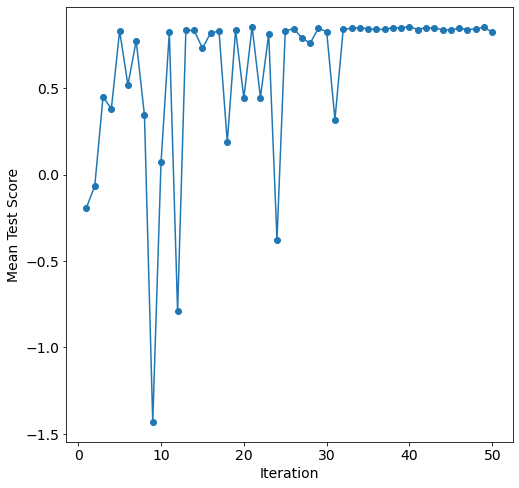

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="nn")

After about 35 iterations the bayesian search converges on the optimal solution for this parameter space.

## Model Post-processing

With the models tuned and the top `num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. We will increase the `epochs` of the `nn` models for better performance.

In [17]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\bar{y}$ is the model predicted outcome, and $n$ is the number of observations.

In [18]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
16,rforest,"{'criterion': 'squared_error', 'max_features':...",0.997404,0.007136,0.000138,0.011738,0.995787,0.010831,0.000209,0.014444
19,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.997815,0.006715,0.000116,0.010768,0.995406,0.011192,0.000227,0.015083
20,rforest,"{'criterion': 'poisson', 'max_features': 6, 'm...",0.995361,0.009481,0.000246,0.015692,0.994371,0.011828,0.000279,0.016696
18,rforest,"{'criterion': 'poisson', 'max_features': 4, 'm...",0.998028,0.006084,0.000105,0.010230,0.993181,0.012074,0.000338,0.018375
17,rforest,"{'criterion': 'poisson', 'max_features': 4, 'm...",0.998036,0.006409,0.000104,0.010208,0.993104,0.012991,0.000341,0.018480
6,dtree,"{'max_depth': 23, 'max_features': 6, 'min_samp...",0.996496,0.009143,0.000186,0.013638,0.987863,0.018906,0.000601,0.024516
8,dtree,"{'max_depth': 38, 'max_features': None, 'min_s...",0.997899,0.006573,0.000112,0.010561,0.987159,0.019439,0.000636,0.025217
9,dtree,"{'max_depth': 28, 'max_features': None, 'min_s...",0.996850,0.008135,0.000167,0.012931,0.986963,0.019320,0.000646,0.025408
10,dtree,"{'max_depth': 28, 'max_features': None, 'min_s...",0.996938,0.008514,0.000163,0.012748,0.986811,0.019505,0.000653,0.025555
7,dtree,"{'max_depth': 34, 'max_features': 6, 'min_samp...",0.996311,0.008674,0.000196,0.013993,0.981499,0.022404,0.000916,0.030267


As this data set represents radial heat conduction, we do not expect linear models to perform well. This is shown by the relatively poor performance of `linear` and `lasso`. The best perfroming models were `rforest` and `dtree` with test and train r-squared above 0.99. 

Using the `get_params` function we can see the optimal hyper-parameter configurations for each model.

In [19]:
for model in ["linear", "lasso", "svr", "dtree", "knn", "rforest", "nn"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs  positive
0      linear    True           True   None     False 

  Model Types    alpha
0       lasso  0.00018 

  Model Types  degree  gamma kernel
0         svr       1  scale   poly 

  Model Types  max_depth  max_features  min_samples_leaf  min_samples_split
0       dtree         23             6                 2                  8 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn         17            9  1  distance 

  Model Types      criterion  max_features  min_samples_leaf  \
0     rforest  squared_error             6                 2   

   min_samples_split  n_estimators  
0                  6            72   

  Model Types  batch_size  learning_rate mid_num_node_strategy  num_layers  \
0          nn           8          0.001                linear           2   

   start_num_nodes  
0              300   



To visualize the performance of these models we can use the `diagonal_validation_plot` functions to produce diagonal validation plots.

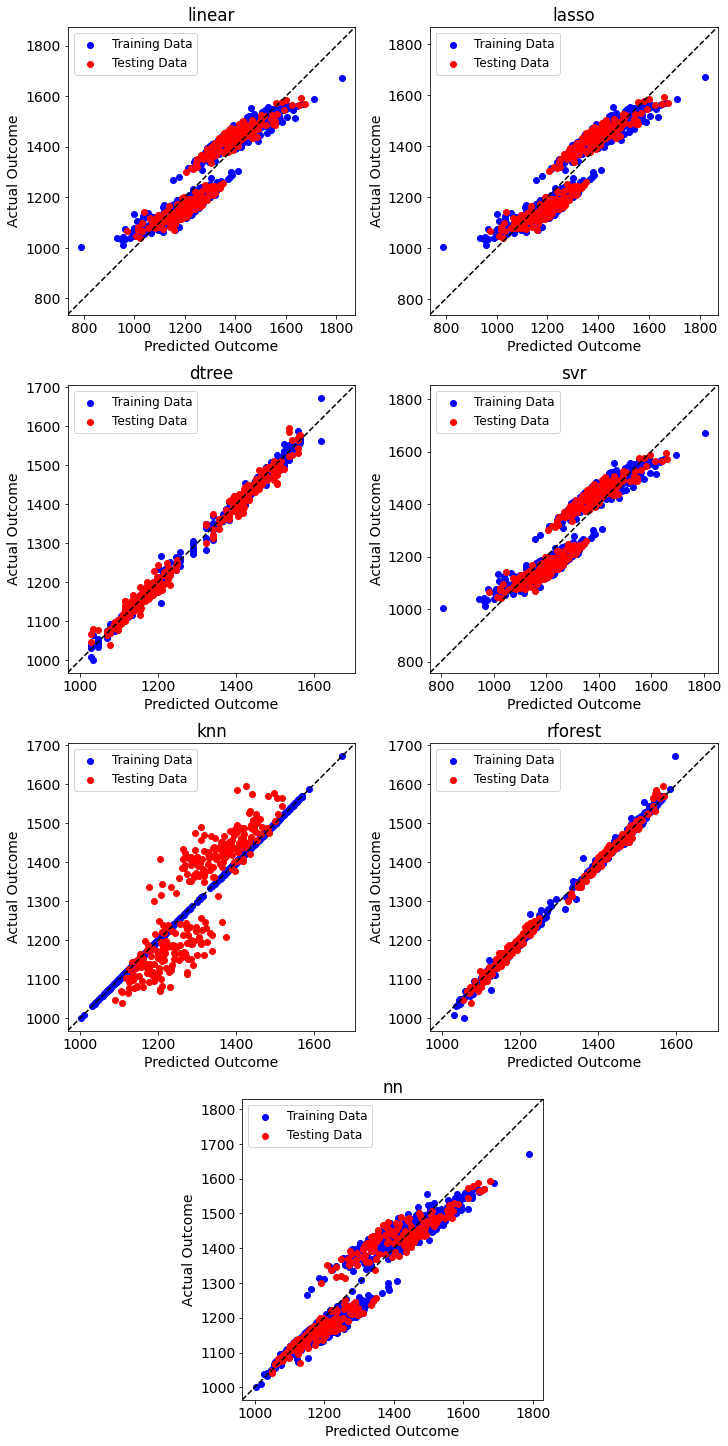

In [20]:
models = np.array([["linear", "lasso"], ["dtree", "svr"], ["knn", "rforest"], ["nn", None]])

fig = plt.figure(constrained_layout=fig, figsize=(10,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0] - 1):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(model_type=models[i, j], yscaler=preprocessor.yscaler)
            ax.set_title(models[i, j])
ax = fig.add_subplot(gs[-1, :])
ax = postprocessor.diagonal_validation_plot(model_type=models[-1, 0], yscaler=preprocessor.yscaler)
_ = ax.set_title(models[-1, 0])

The performance differences between `rforest`/`dtree` with the other models is apparent along with the overfitting of `knn`. The predictions of `rforest` and `dtree` are closely spread along $y=x$ while the `knn` test predictions are over-predicted at lower temperatures and under-predicted at higher temperatures.

Similarly, the `validation_plot` function produces validation plots that show the absolute relative error for each prediction.

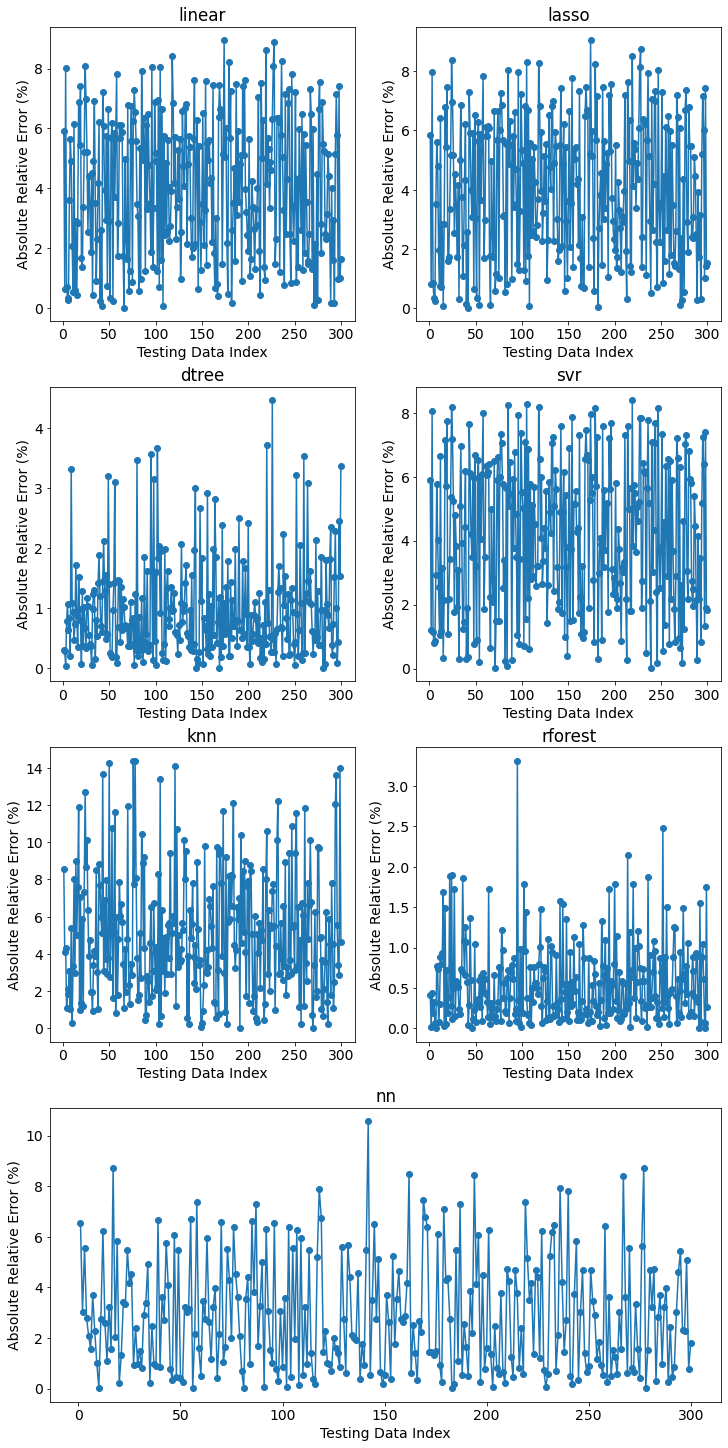

In [21]:
fig = plt.figure(constrained_layout=fig, figsize=(10,20))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0] - 1):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.validation_plot(model_type=models[i, j], yscaler=preprocessor.yscaler)
            ax.set_title(models[i, j])
ax = fig.add_subplot(gs[-1, :])
ax = postprocessor.validation_plot(model_type=models[-1, 0], yscaler=preprocessor.yscaler)
_ = ax.set_title(models[-1, 0])

The performance of the models is best represented by the magnitudes observed on the y-axis; however, even `rforest` gets as high as $>3.0\%$ error. 

Finally, the learning curve of the most performant `nn` is shown by `nn_learning_plot`.

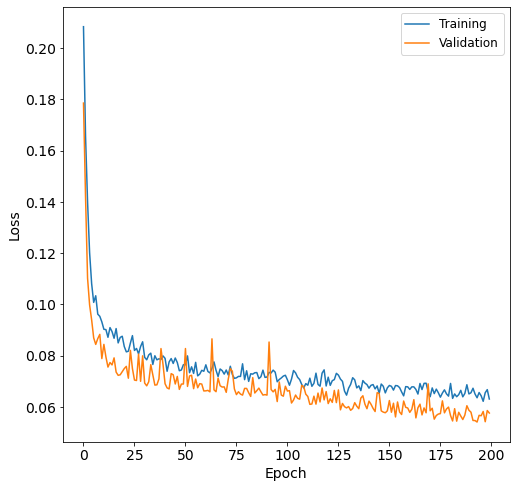

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

The validation curve is below the training curve; therefore, the `nn` is not overfit. 

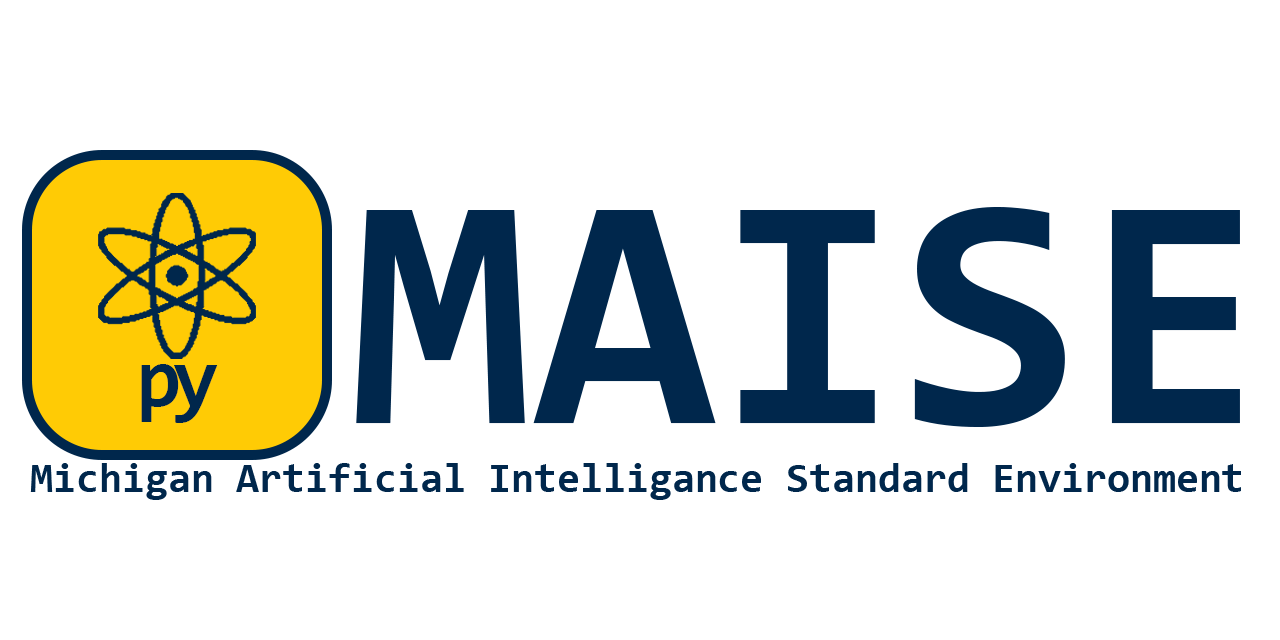